<a href="https://colab.research.google.com/github/Amirnaderiy/CNN_ViT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install efficientnet
!pip install tensorflow_addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
 
import tensorflow as tf
import os , shutil
import cv2
from keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler, LambdaCallback, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import math

from google.colab import files
from google.colab import drive


In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/250
25/25 [==============================] - 91s 3s/step - loss: 3.0717 - accuracy: 0.3860 - val_loss: 14.8027 - val_accuracy: 0.2642
Epoch 2/250
25/25 [==============================] - 59s 2s/step - loss: 2.5225 - accuracy: 0.4767 - val_loss: 17.2066 - val_accuracy: 0.2176
Epoch 3/250
25/25 [==============================] - 63s 3s/step - loss: 2.2836 - accuracy: 0.5311 - val_loss: 9.4404 - val_accuracy: 0.1762
Epoch 4/250
25/25 [==============================] - 62s 2s/step - loss: 2.1849 - accuracy: 0.5181 - val_loss: 13.9502 - val_accuracy: 0.2073
Epoch 5/250
25/25 [==============================] - 68s 3s/step - loss: 1.8440 - accuracy: 0.6010 - val_loss: 9.2997 - val_accuracy: 0.2435
Epoch 6/250
25/25 [==============================] - 62s 3s/step - loss: 1.9985 - accuracy: 0.5363 - val_loss: 23.7956 - val_accuracy: 0.1658
Epoch 7/250
25/25 [==============================] - 62s 2s/step - loss: 1.8582 - accuracy: 0.6036 - val_loss: 17.5608 - val_accuracy: 0.1865
Epoch 8/

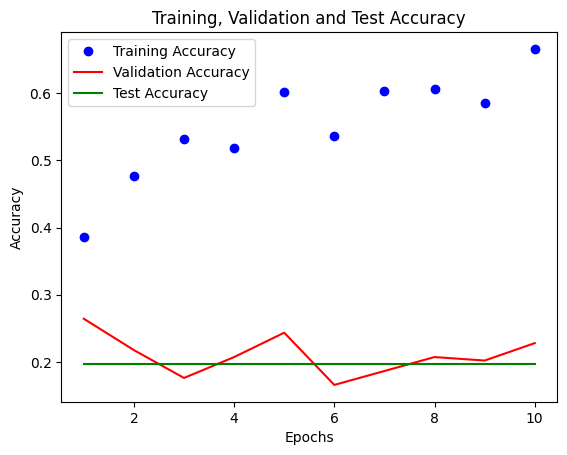

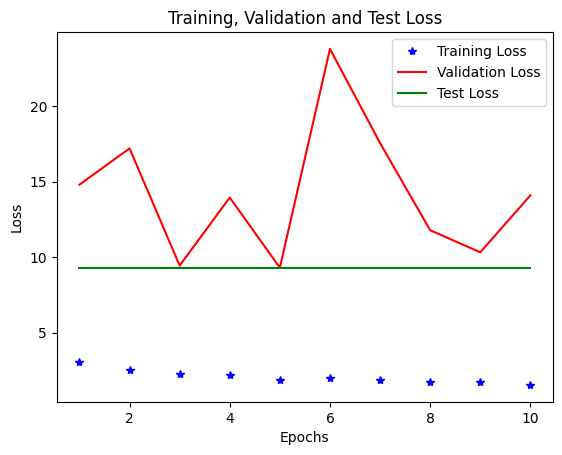

In [3]:
original_dataset_dir = '/content/drive/MyDrive/B-Mode Ultrasound/'


# Define the four groups based on the filename
group0 = [filename for filename in os.listdir(original_dataset_dir) if filename.startswith('Group0')]
group1 = [filename for filename in os.listdir(original_dataset_dir) if filename.startswith('Group1')]
group2 = [filename for filename in os.listdir(original_dataset_dir) if filename.startswith('Group2')]
group3 = [filename for filename in os.listdir(original_dataset_dir) if filename.startswith('Group3')]

# Define a function to load the images and resize them to a specific size
def load_and_resize_image(filename, target_size):
    img = cv2.imread(os.path.join(original_dataset_dir, filename))
    img = cv2.resize(img, target_size)
    return img

# Define the target size for the images
target_size = (224, 224)

# Load the images for each group and resize them
group0_images = [load_and_resize_image(filename, target_size) for filename in group0]
group1_images = [load_and_resize_image(filename, target_size) for filename in group1]
group2_images = [load_and_resize_image(filename, target_size) for filename in group2]
group3_images = [load_and_resize_image(filename, target_size) for filename in group3]

# Define the labels for each group
group0_labels = [0] * len(group0_images)
group1_labels = [1] * len(group1_images)
group2_labels = [2] * len(group2_images)
group3_labels = [3] * len(group3_images)

images = group0_images + group1_images + group2_images + group3_images
labels = group0_labels + group1_labels + group2_labels + group3_labels

# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.30, random_state=42)

# Split the train set into train and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.50, random_state=42)

target_size = (384, 384)

# Load the images for each group and resize them
group0_images = [load_and_resize_image(filename, target_size) for filename in group0]
group1_images = [load_and_resize_image(filename, target_size) for filename in group1]
group2_images = [load_and_resize_image(filename, target_size) for filename in group2]
group3_images = [load_and_resize_image(filename, target_size) for filename in group3]

# Define the labels for each group
group0_labels = [0] * len(group0_images)
group1_labels = [1] * len(group1_images)
group2_labels = [2] * len(group2_images)
group3_labels = [3] * len(group3_images)

images = group0_images + group1_images + group2_images + group3_images
labels = group0_labels + group1_labels + group2_labels + group3_labels

# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.30, random_state=42)

# Split the train set into train and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.50, random_state=42)

    
image_size = 384

# Define the number of classes
num_classes=4

# Load the Swin Transformer model
swin = hub.KerasLayer("https://tfhub.dev/sayakpaul/swin_large_patch4_window12_384_in22k/1")


# Add your own fully connected layers
model = models.Sequential()
model.add(swin)
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Define the batch size for training and validation
batch_size = 16

# Define the data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)



test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow(
    x=np.array(train_images),
    y=tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
    batch_size=batch_size,
    shuffle=True
)

validation_generator = val_datagen.flow(
    x=np.array(val_images),
    y=tf.keras.utils.to_categorical(val_labels, num_classes=num_classes),
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow(
    x=np.array(test_images),
    y=tf.keras.utils.to_categorical(test_labels, num_classes=num_classes),
    batch_size=batch_size,
    shuffle=False
)
    
    


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=["accuracy", Precision(), Recall()])

    
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=250, 
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

history_dict=history.history
accuracy_values=history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
test_accuracy_values = [test_acc] * len(accuracy_values)
epochs=range(1,len(accuracy_values)+1)
plt.plot (epochs,accuracy_values,'bo',label='Training Accuracy')
plt.plot (epochs,val_accuracy_values,'r',label='Validation Accuracy')
plt.plot (epochs,test_accuracy_values,'g',label='Test Accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

accuracy_values=history_dict['loss']
val_accuracy_values=history_dict['val_loss']
test_loss_values = [test_loss] * len(accuracy_values)
epochs=range(1,len(accuracy_values)+1)
plt.plot (epochs,accuracy_values,'b*',label='Training Loss')
plt.plot (epochs,val_accuracy_values,'r',label='Validation Loss')
plt.plot (epochs,test_loss_values,'g',label='Test Loss')
plt.title('Training, Validation and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
history_dict=history.history
accuracy_values=history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
test_accuracy_values = [test_acc] * len(accuracy_values)
epochs=range(1,len(accuracy_values)+1)
plt.plot (epochs,accuracy_values,'bo',label='Training Accuracy')
plt.plot (epochs,val_accuracy_values,'r',label='Validation Accuracy')
plt.plot (epochs,test_accuracy_values,'g',label='Test Accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

accuracy_values=history_dict['loss']
val_accuracy_values=history_dict['val_loss']
test_loss_values = [test_loss] * len(accuracy_values)
epochs=range(1,len(accuracy_values)+1)
plt.plot (epochs,accuracy_values,'b*',label='Training Loss')
plt.plot (epochs,val_accuracy_values,'r',label='Validation Loss')
plt.plot (epochs,test_loss_values,'g',label='Test Loss')
plt.title('Training, Validation and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()